## Group 2: Ames Housing Data Project

Here we will use the Ames Housing data provided in order to determine the sale price of a house depending on the amount of data given.  We will first need to analyze and clean the data and then determine the best machine learning models to use in order to have some regression on the data.  

First we will need to import our relevant libraries (mylearn and util are those posted by Dr. Qi) and our training data

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import util
import mylearn
import time
np.random.seed(1)

In [2]:
data = pd.read_csv('train.csv') #pre-downloaded housing data

In [3]:
data.head(5) #confirms that our data is indeed being imported correctly.

,Id,MSSubClass,MSZoning,LotFrontage,LotArea,Street,Alley,LotShape,LandContour,Utilities,...,PoolArea,PoolQC,Fence,MiscFeature,MiscVal,MoSold,YrSold,SaleType,SaleCondition,SalePrice
0,1,60,RL,65.0,8450,Pave,NaN,Reg,Lvl,AllPub,...,0,NaN,NaN,NaN,0,2,2008,WD,Normal,208500
1,2,20,RL,80.0,9600,Pave,NaN,Reg,Lvl,AllPub,...,0,NaN,NaN,NaN,0,5,2007,WD,Normal,181500
2,3,60,RL,68.0,11250,Pave,NaN,IR1,Lvl,AllPub,...,0,NaN,NaN,NaN,0,9,2008,WD,Normal,223500
3,4,70,RL,60.0,9550,Pave,NaN,IR1,Lvl,AllPub,...,0,NaN,NaN,NaN,0,2,2006,WD,Abnorml,140000
4,5,60,RL,84.0,14260,Pave,NaN,IR1,Lvl,AllPub,...,0,NaN,NaN,NaN,0,12,2008,WD,Normal,250000


In [4]:
data.shape

(1460, 81)

In [5]:
data.columns

Index(['Id', 'MSSubClass', 'MSZoning', 'LotFrontage', 'LotArea', 'Street',
       'Alley', 'LotShape', 'LandContour', 'Utilities', 'LotConfig',
       'LandSlope', 'Neighborhood', 'Condition1', 'Condition2', 'BldgType',
       'HouseStyle', 'OverallQual', 'OverallCond', 'YearBuilt', 'YearRemodAdd',
       'RoofStyle', 'RoofMatl', 'Exterior1st', 'Exterior2nd', 'MasVnrType',
       'MasVnrArea', 'ExterQual', 'ExterCond', 'Foundation', 'BsmtQual',
       'BsmtCond', 'BsmtExposure', 'BsmtFinType1', 'BsmtFinSF1',
       'BsmtFinType2', 'BsmtFinSF2', 'BsmtUnfSF', 'TotalBsmtSF', 'Heating',
       'HeatingQC', 'CentralAir', 'Electrical', '1stFlrSF', '2ndFlrSF',
       'LowQualFinSF', 'GrLivArea', 'BsmtFullBath', 'BsmtHalfBath', 'FullBath',
       'HalfBath', 'BedroomAbvGr', 'KitchenAbvGr', 'KitchenQual',
       'TotRmsAbvGrd', 'Functional', 'Fireplaces', 'FireplaceQu', 'GarageType',
       'GarageYrBlt', 'GarageFinish', 'GarageCars', 'GarageArea', 'GarageQual',
       'GarageCond', 'PavedDrive

In [6]:
House = data.copy()  #this gives us a new dataframe ot play with without deleting the actual data

First we'll note that there are 81 columns, we can drop the ID column as we know it is irrelevant.  Additionally, in order to categorize the variables, we'll make a histogram of the Sale Price.

In [7]:
House = House.drop('Id', axis = 1)

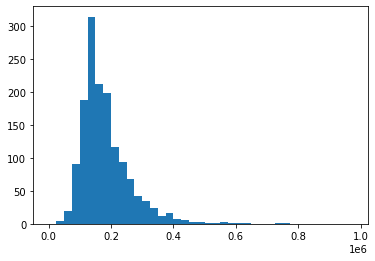

In [8]:
bins = np.arange(40)*25000
plt.hist(House['SalePrice'], bins = bins)
plt.show()

Using a bin size of \$25000, we can see a peak at about 150,000 and a long tail after that.  Therefore, in order to improve affordability decisions for whoever may be using this dataset, we will split it into five classes as below:

Class 0: Sale Price < 100,000  

Class 1: Sale Price 100,000 - 150,000  

Class 2: Sale Price 150,000 - 200,000  

Class 3: Sale Price 200,000 - 250,000  

Class 4: Sale Price > 250,000  

This allows us to generalize the classes near the mean while noting outliers so we can take them from our analysis.

In [9]:
def create_classes(dat, col = 'SalePrice'):#creates a definition that creates a class definition
    val = dat[col]
    if val < 100000: return 0
    elif val <150000: return 1
    elif val <200000: return 2
    elif val <250000: return 3
    else: return 4

In [10]:
House.apply(create_classes, axis = 1)

0       3
1       2
2       3
3       1
4       4
       ..
1455    2
1456    3
1457    4
1458    1
1459    1
Length: 1460, dtype: int64

In [11]:
House['SaleClass']= House.apply(create_classes, axis = 1)

In [12]:
House.head()

,MSSubClass,MSZoning,LotFrontage,LotArea,Street,Alley,LotShape,LandContour,Utilities,LotConfig,...,PoolQC,Fence,MiscFeature,MiscVal,MoSold,YrSold,SaleType,SaleCondition,SalePrice,SaleClass
0,60,RL,65.0,8450,Pave,NaN,Reg,Lvl,AllPub,Inside,...,NaN,NaN,NaN,0,2,2008,WD,Normal,208500,3
1,20,RL,80.0,9600,Pave,NaN,Reg,Lvl,AllPub,FR2,...,NaN,NaN,NaN,0,5,2007,WD,Normal,181500,2
2,60,RL,68.0,11250,Pave,NaN,IR1,Lvl,AllPub,Inside,...,NaN,NaN,NaN,0,9,2008,WD,Normal,223500,3
3,70,RL,60.0,9550,Pave,NaN,IR1,Lvl,AllPub,Corner,...,NaN,NaN,NaN,0,2,2006,WD,Abnorml,140000,1
4,60,RL,84.0,14260,Pave,NaN,IR1,Lvl,AllPub,FR2,...,NaN,NaN,NaN,0,12,2008,WD,Normal,250000,4


Next, in order to test the accuracy of our dataset (as our testing set does not have sale prices), we will randomly choose 25% of our dataset to turn into a validations dataset.  We will have to choose this randomly

In [13]:
replace_index = np.random.choice(len(House), size = int(len(House)/4), replace = False)

In [14]:
Houseval = House.iloc[replace_index]

In [15]:
Housetrain= House.drop(replace_index)

In [16]:
Houseval.shape

(365, 81)

In [17]:
Housetrain.shape

(1095, 81)

In order to test our values, we will reduce rows to only those which contain values where order matters (as opposed to subclasses or zoning values where quality is not obvious), additionally, we will convert years values to years since sold/years since remodels. Note that in the future we will want to create dummy variables for some of the categorical variables and determine which functions are more likely to impact the final sale price using correlations.  Note that variables where the values matter but are somewhat categorical (like overall value which much be an integer), we will keep, but those which are only given cateogries (such as basement finish area rating) we will ignore.  We will also drop those values dependent on cateogries we drop (such as amount of Basement finish area created.

For these values, we will replace any unknown values with 0.  The exception to this being the years built values, which we will replace with the maximum after conversion.  We will also convert month and year sold to months since December 2010 (since Jan 2006 is likely closer to March of 2006 than Jan of 2010

This will leave us with the following rows for identification:

- LotFrontage
- LotArea
- OverallQual
- OverallCond
- YearBuilt (converted to years since built, using 2010 as a base year as that's when the dataset was created)
- YearRemodAdd (converted to years before 2010)
- MasVnrArea
- BsmtUnfSF
- TotalBsmtSF
- 1stFlrSF
- 2ndFlrSF
- LowQualFinSF
- GrLivArea
- BsmtFullBath
- BsmtHalfBath
- FullBath
- HalfBath
- BedroomAbvGr
- KitchenAbvGr
- TotRmsAbvGrd
- Fireplaces
- GarageYrBlt (converted to years before 2010)
- GarageCars
- GarageArea
- WoodDeckSF
- OpenPorchSF
- EnclosedPorch
- 3SsnPorch
- ScreenPorch
- PoolArea
- MiscVal
- MoSold
- YrSold

In [18]:
cats = ['LotFrontage', 'LotArea', 'OverallQual', 'OverallCond', 'YearBuilt', 'YearRemodAdd', 'MasVnrArea', 'BsmtUnfSF',
       'TotalBsmtSF', '1stFlrSF', '2ndFlrSF', 'LowQualFinSF', 'GrLivArea', 'BsmtFullBath', 'BsmtHalfBath', 'FullBath',
       'HalfBath', 'BedroomAbvGr', 'KitchenAbvGr', 'TotRmsAbvGrd', 'Fireplaces', 'GarageYrBlt', 'GarageCars', 'GarageArea',
       'WoodDeckSF', 'OpenPorchSF', 'EnclosedPorch','3SsnPorch', 'ScreenPorch', 'PoolArea', 'MiscVal', 'MoSold', 'YrSold']
target = 'SaleClass'

In [19]:
Housetrain[cats].isnull().sum()

LotFrontage      200
LotArea            0
OverallQual        0
OverallCond        0
YearBuilt          0
YearRemodAdd       0
MasVnrArea         7
BsmtUnfSF          0
TotalBsmtSF        0
1stFlrSF           0
2ndFlrSF           0
LowQualFinSF       0
GrLivArea          0
BsmtFullBath       0
BsmtHalfBath       0
FullBath           0
HalfBath           0
BedroomAbvGr       0
KitchenAbvGr       0
TotRmsAbvGrd       0
Fireplaces         0
GarageYrBlt       54
GarageCars         0
GarageArea         0
WoodDeckSF         0
OpenPorchSF        0
EnclosedPorch      0
3SsnPorch          0
ScreenPorch        0
PoolArea           0
MiscVal            0
MoSold             0
YrSold             0
dtype: int64

In [20]:
Houseval[cats].isnull().sum()

LotFrontage      59
LotArea           0
OverallQual       0
OverallCond       0
YearBuilt         0
YearRemodAdd      0
MasVnrArea        1
BsmtUnfSF         0
TotalBsmtSF       0
1stFlrSF          0
2ndFlrSF          0
LowQualFinSF      0
GrLivArea         0
BsmtFullBath      0
BsmtHalfBath      0
FullBath          0
HalfBath          0
BedroomAbvGr      0
KitchenAbvGr      0
TotRmsAbvGrd      0
Fireplaces        0
GarageYrBlt      27
GarageCars        0
GarageArea        0
WoodDeckSF        0
OpenPorchSF       0
EnclosedPorch     0
3SsnPorch         0
ScreenPorch       0
PoolArea          0
MiscVal           0
MoSold            0
YrSold            0
dtype: int64

Fortunately we see there are only null values in 3 columsn.  Lot Frontage and MasVnrArea we can easily replace with 0.  GarageYrBuilt is likely referring to houses without garages, we will replace those with the minimum of our training set (not validation set) year built, then convert our year values.  We'll also note that houses that weren't remodeled have the most recent year remodel addition as the same as the year they were built.

In [21]:
traintarget = Housetrain[target]
valtarget = Houseval[target]
Housetrain = Housetrain[cats]
Houseval = Houseval[cats]

In [22]:
Housetrain['HouseAge']=2010 - Housetrain['YearBuilt']
Houseval['HouseAge'] = 2010 - Houseval['YearBuilt']
Housetrain.drop('YearBuilt', axis =1, inplace = True)
Houseval.drop('YearBuilt', axis = 1, inplace = True)

In [23]:
Housetrain['RemodAge']=2010 - Housetrain['YearRemodAdd']
Houseval['RemodAge'] = 2010 - Houseval['YearRemodAdd']
Housetrain.drop('YearRemodAdd', axis =1, inplace = True)
Houseval.drop('YearRemodAdd', axis = 1, inplace = True)

In [24]:
fillvals = {'LotFrontage': 0, 'MasVnrArea': 0, 'GarageYrBlt': min(Housetrain['GarageYrBlt'])}  #creates fill values

In [25]:
Housetrain.fillna(value = fillvals, inplace = True)
Houseval.fillna(value = fillvals, inplace = True)

In [26]:
Housetrain.isnull().sum().sum()

0

In [27]:
Houseval.isnull().sum().sum()

0

In [28]:
Housetrain['GarageAge']=2010 - Housetrain['GarageYrBlt']
Houseval['GarageAge'] = 2010 - Houseval['GarageYrBlt']
Housetrain.drop('GarageYrBlt', axis =1, inplace = True)
Houseval.drop('GarageYrBlt', axis = 1, inplace = True)

In [29]:
Housetrain['MonthsSold']= 12*(2010 - Housetrain['YrSold'])+(12-Housetrain['MoSold'])
Houseval['MonthsSold']= 12*(2010 - Houseval['YrSold'])+(12-Houseval['MoSold'])
Housetrain.drop(['YrSold', 'MoSold'], axis = 1, inplace = True)
Houseval.drop(['YrSold', 'MoSold'], axis = 1, inplace = True)

In [30]:
len(Housetrain.columns)

32

We now have a 32 dimensional DataFrame with 5 classes and one target.  We will attempt to apply MPP (with Gaussian and Mahalanobis distance, Case 3 leads to a singular matrix error), and knn  (k = 100) on our training set and use the results on our testing set to determine accuracy.  As the data was simply cleaned without relevance, we'd expect relatively low accuracy right now.  Note that random choice accuracy will be 20%.  We will also take the probability from our training set to determine the prior probabilities (since they're clearly not equal)

In [31]:
probs = []
for val in np.unique(traintarget):
    prob = sum(traintarget == val)/len(traintarget)
    probs.append(prob)

In [32]:
probs

[0.0730593607305936,
 0.3415525114155251,
 0.27671232876712326,
 0.15159817351598173,
 0.15707762557077626]

In [33]:
ts = time.time()
ValMPP1 = mylearn.mpp(np.array(Housetrain), np.array(traintarget), np.array(Houseval), 1, probs)
tMPP1 = time.time() - ts

Sample 0: label is 2.0
Sample 100: label is 1.0
Sample 200: label is 1.0
Sample 300: label is 1.0


In [34]:
ts = time.time()
ValMPP2 = mylearn.mpp(np.array(Housetrain), np.array(traintarget), np.array(Houseval), 2, probs)
tMPP2 = time.time() - ts

Sample 0: label is 2.0
Sample 100: label is 1.0
Sample 200: label is 3.0
Sample 300: label is 2.0


In [35]:
ts = time.time()
ValKNN = mylearn.knn(np.array(Housetrain), np.array(traintarget), np.array(Houseval), 100)
tKNN = time.time() - ts

Sample 0: label is 2.0
Sample 100: label is 2.0
Sample 200: label is 2.0
Sample 300: label is 1.0


In [36]:
MPP1ClassAcc, MPP1OvAcc = util.accuracy_score(np.array(valtarget), ValMPP1) 
MPP2ClassAcc, MPP2OvAcc = util.accuracy_score(np.array(valtarget), ValMPP2) 
KNNClassAcc, KNNOvAcc = util.accuracy_score(np.array(valtarget), ValKNN)

In [37]:
for val in np.unique(traintarget):
    print(f'MPP (Case 1) accuracy for Class {val} = {MPP1ClassAcc[val]}.')
    print(f'MPP (Case 2) accuracy for Class {val} = {MPP2ClassAcc[val]}.')
    print(f'KNN accuracy for Class {val} = {KNNClassAcc[val]}.')
print(f'Overall Accuracy for for MPP (Case 1) is {MPP1OvAcc}')
print(f'Overall Accuracy for for MPP (Case 2) is {MPP2OvAcc}')
print(f'Overall Accuracy for for KNN is {KNNOvAcc}')
print(f'Training time for MPP (Case 1) is {tMPP1}')
print(f'Training time for MPP (Case 2) is {tMPP1}')
print(f'Training time for KNN is {tKNN}')

MPP (Case 1) accuracy for Class 0 = 0.0.
MPP (Case 2) accuracy for Class 0 = 0.8235294117647058.
KNN accuracy for Class 0 = 0.0.
MPP (Case 1) accuracy for Class 1 = 0.937007874015748.
MPP (Case 2) accuracy for Class 1 = 0.7874015748031497.
KNN accuracy for Class 1 = 0.7716535433070866.
MPP (Case 1) accuracy for Class 2 = 0.09345794392523364.
MPP (Case 2) accuracy for Class 2 = 0.5046728971962616.
KNN accuracy for Class 2 = 0.40186915887850466.
MPP (Case 1) accuracy for Class 3 = 0.0.
MPP (Case 2) accuracy for Class 3 = 0.4318181818181818.
KNN accuracy for Class 3 = 0.022727272727272728.
MPP (Case 1) accuracy for Class 4 = 0.16981132075471697.
MPP (Case 2) accuracy for Class 4 = 0.7169811320754716.
KNN accuracy for Class 4 = 0.6226415094339622.
Overall Accuracy for for MPP (Case 1) is 0.3780821917808219
Overall Accuracy for for MPP (Case 2) is 0.6547945205479452
Overall Accuracy for for KNN is 0.4794520547945205
Training time for MPP (Case 1) is 0.011939048767089844
Training time for MP

We'll note that the Euclidean and Mahalanobis distances in this case gave us the exact same decisions in this case, showing that many of the items may truly be unrelated.  We'll note that distance from the mean seemed to be an ok discriminator with near 80% accuracy on a 5 class set while KNN did quite poorly.  We'll also note that KNN seemed to favor classes 1 and 4 while not even identifying any house as class 0 and identifying very few as class 3.  This may be an issue with our categorization that we don't see in the others.  Notably, MPP did the best with these classes as well (though of course showed much better results in the clases for which it faired poorly.

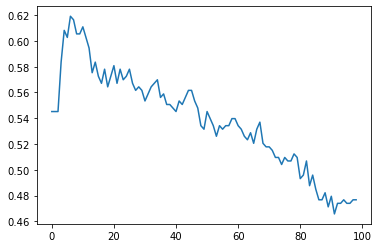

In [38]:
# find the best k
accs = []
for k in range(1, 100):
    ValKNN = mylearn.knn(np.array(Housetrain), np.array(traintarget), np.array(Houseval), k, output=False)
    _, KNNOvAcc = util.accuracy_score(np.array(valtarget), ValKNN)
    accs.append(KNNOvAcc)
plt.plot(accs)

The best k is roughly 8.

In [39]:
ts = time.time()
ValKNN = mylearn.knn(np.array(Housetrain), np.array(traintarget), np.array(Houseval), 8)
tKNN = time.time() - ts
KNNClassAcc, KNNOvAcc = util.accuracy_score(np.array(valtarget), ValKNN) 
for val in np.unique(traintarget):
    print(f'KNN accuracy for Class {val} = {KNNClassAcc[val]}.')
print(f'Overall Accuracy for for KNN is {KNNOvAcc}')
print(f'Training time for KNN is {tKNN}')

Sample 0: label is 2.0
Sample 100: label is 3.0
Sample 200: label is 2.0
Sample 300: label is 2.0
KNN accuracy for Class 0 = 0.2647058823529412.
KNN accuracy for Class 1 = 0.6929133858267716.
KNN accuracy for Class 2 = 0.7383177570093458.
KNN accuracy for Class 3 = 0.29545454545454547.
KNN accuracy for Class 4 = 0.6792452830188679.
Overall Accuracy for for KNN is 0.6164383561643836
Training time for KNN is 0.06527161598205566


# bin with same width vs. bin with same quantity

Instead of just using bins with equivalent widthes, we would also like to know what if we use bins that contains the same number of samples. The "quarter1" below is 0.2 quantile. "Quarter2" is 0.4 quantile ... 

In [40]:
quarter1, quarter2, quarter3, quarter4 = House.SalePrice.quantile([0.2, 0.4, 0.6, 0.8]) 

def create_classes_same_quantity(dat, col = 'SalePrice'):#creates a definition that creates a class definition
    val = dat[col]
    if val < quarter1: return 0
    elif val < quarter2: return 1
    elif val < quarter3: return 2
    elif val < quarter4: return 3
    else: return 4
    
House['SaleClass2'] = House.apply(create_classes_same_quantity, axis = 1)

In [41]:
House.head(5)

,MSSubClass,MSZoning,LotFrontage,LotArea,Street,Alley,LotShape,LandContour,Utilities,LotConfig,...,Fence,MiscFeature,MiscVal,MoSold,YrSold,SaleType,SaleCondition,SalePrice,SaleClass,SaleClass2
0,60,RL,65.0,8450,Pave,NaN,Reg,Lvl,AllPub,Inside,...,NaN,NaN,0,2,2008,WD,Normal,208500,3,3
1,20,RL,80.0,9600,Pave,NaN,Reg,Lvl,AllPub,FR2,...,NaN,NaN,0,5,2007,WD,Normal,181500,2,3
2,60,RL,68.0,11250,Pave,NaN,IR1,Lvl,AllPub,Inside,...,NaN,NaN,0,9,2008,WD,Normal,223500,3,3
3,70,RL,60.0,9550,Pave,NaN,IR1,Lvl,AllPub,Corner,...,NaN,NaN,0,2,2006,WD,Abnorml,140000,1,1
4,60,RL,84.0,14260,Pave,NaN,IR1,Lvl,AllPub,FR2,...,NaN,NaN,0,12,2008,WD,Normal,250000,4,4


The function "data_clean" below just gather the codes appeared above. To compare these two kinds of bins in a fair manner, we have to make sure the samples used is identicial for them. Therefore, we need to regenerate them.

In [42]:
def data_clean(House):
    replace_index = np.random.choice(len(House), size = int(len(House)/4), replace = False)
    Houseval = House.iloc[replace_index]
    Housetrain= House.drop(replace_index)
    traintarget = Housetrain['SaleClass'] # same width
    traintarget2 = Housetrain['SaleClass2'] # same quantity
    valtarget = Houseval['SaleClass']
    valtarget2 = Houseval['SaleClass2']
    Housetrain = Housetrain[cats]
    Houseval = Houseval[cats]
    Housetrain['HouseAge']=2010 - Housetrain['YearBuilt']
    Houseval['HouseAge'] = 2010 - Houseval['YearBuilt']
    Housetrain.drop('YearBuilt', axis =1, inplace = True)
    Houseval.drop('YearBuilt', axis = 1, inplace = True)
    Housetrain['RemodAge']=2010 - Housetrain['YearRemodAdd']
    Houseval['RemodAge'] = 2010 - Houseval['YearRemodAdd']
    Housetrain.drop('YearRemodAdd', axis =1, inplace = True)
    Houseval.drop('YearRemodAdd', axis = 1, inplace = True)
    fillvals = {'LotFrontage': 0, 'MasVnrArea': 0, 'GarageYrBlt': min(Housetrain['GarageYrBlt'])}  #creates fill values
    Housetrain.fillna(value = fillvals, inplace = True)
    Houseval.fillna(value = fillvals, inplace = True)
    Housetrain['GarageAge']=2010 - Housetrain['GarageYrBlt']
    Houseval['GarageAge'] = 2010 - Houseval['GarageYrBlt']
    Housetrain.drop('GarageYrBlt', axis =1, inplace = True)
    Houseval.drop('GarageYrBlt', axis = 1, inplace = True)
    Housetrain['MonthsSold']= 12*(2010 - Housetrain['YrSold'])+(12-Housetrain['MoSold'])
    Houseval['MonthsSold']= 12*(2010 - Houseval['YrSold'])+(12-Houseval['MoSold'])
    Housetrain.drop(['YrSold', 'MoSold'], axis = 1, inplace = True)
    Houseval.drop(['YrSold', 'MoSold'], axis = 1, inplace = True)
    probs = []
    for val in np.unique(traintarget):
        prob = sum(traintarget == val)/len(traintarget)
        probs.append(prob)
    probs2 = []
    for val in np.unique(traintarget2):
        prob = sum(traintarget2 == val)/len(traintarget2)
        probs2.append(prob)
    return Housetrain, traintarget, Houseval, valtarget, probs, traintarget2, valtarget2, probs2

In [43]:
Housetrain, traintarget, Houseval, valtarget, probs, traintarget2, valtarget2, probs2 = data_clean(House)

In [44]:
def experiment(tr, trtarget, val, valtarget, prob):  # test the effect of normalization on knn, mpp1, and mpp2
    Val = mylearn.knn(np.array(tr), np.array(trtarget), np.array(val), 8, output=False)
    ClassAcc, OvAcc1 = util.accuracy_score(np.array(valtarget), Val) 
    print(f'Overall Accuracy for knn is {OvAcc1}')

    Val = mylearn.mpp(np.array(tr), np.array(trtarget), np.array(val), 1, prob, output=False)
    ClassAcc, OvAcc2 = util.accuracy_score(np.array(valtarget), Val) 
    print(f'Overall Accuracy for mpp1 is {OvAcc2}')

    Val = mylearn.mpp(np.array(tr), np.array(trtarget), np.array(val), 2, prob, output=False)
    ClassAcc, OvAcc3 = util.accuracy_score(np.array(valtarget), Val) 
    print(f'Overall Accuracy for mpp2 is {OvAcc3}')

In [45]:
print('use bin with same width')
experiment(Housetrain, traintarget, Houseval, valtarget, probs)

use bin with same width
Overall Accuracy for knn is 0.5506849315068493
Overall Accuracy for mpp1 is 0.3589041095890411
Overall Accuracy for mpp2 is 0.6520547945205479


In [46]:
print('use bin with same quantity')
experiment(Housetrain, traintarget2, Houseval, valtarget2, probs2)

use bin with same quantity
Overall Accuracy for knn is 0.5123287671232877
Overall Accuracy for mpp1 is 0.3232876712328767
Overall Accuracy for mpp2 is 0.6164383561643836


From the tests above, we don't see improvement by leveling the number of samples in the bins. Besides, we think the original bins are easier to design and understand. Therefore, we maintain our original settings.

# min-max normalization vs. mean normalization

We compared min-max normalization and mean normalization.

In [47]:
def minmax_normal(df):
    return (df-df.min())/(df.max()-df.min())

def mean_normal(df):
    return (df-df.mean())/df.std() 

In [48]:
def experiment(tr, target, val, normalization=None):
    
    if normalization == 'min-max':
        tr= minmax_normal(tr)
        val = minmax_normal(val)
    if normalization == 'mean':
        tr = mean_normal(tr)
        val = mean_normal(val)
    
    # test the effect of normalization on knn, mpp1, and mpp2
    Val = mylearn.knn(np.array(tr), np.array(target), np.array(val), 8, output=False)
    ClassAcc, OvAcc1 = util.accuracy_score(np.array(valtarget), Val) 
    print(f'Overall Accuracy for knn is {OvAcc1}')

    Val = mylearn.mpp(np.array(tr), np.array(target), np.array(val), 1, probs, output=False)
    ClassAcc, OvAcc2 = util.accuracy_score(np.array(valtarget), Val) 
    print(f'Overall Accuracy for mpp1 is {OvAcc2}')

    Val = mylearn.mpp(np.array(tr), np.array(target), np.array(val), 2, probs, output=False)
    ClassAcc, OvAcc3 = util.accuracy_score(np.array(valtarget), Val) 
    print(f'Overall Accuracy for mpp2 is {OvAcc3}')
    
    return OvAcc1, OvAcc2, OvAcc3

In [49]:
print("without any normalization")
acc_knn, acc_mpp1, acc_mpp2 = experiment(Housetrain, traintarget, Houseval, normalization=None)

without any normalization
Overall Accuracy for knn is 0.5506849315068493
Overall Accuracy for mpp1 is 0.3589041095890411
Overall Accuracy for mpp2 is 0.6520547945205479


In [50]:
print("use min-max normalization")
acc_knn_minmax, acc_mpp1_minmax, acc_mpp2_minmax = experiment(Housetrain, traintarget, Houseval, normalization='min-max')

use min-max normalization
Overall Accuracy for knn is 0.6465753424657534
Overall Accuracy for mpp1 is 0.6027397260273972
Overall Accuracy for mpp2 is 0.4520547945205479


In [51]:
print("use mean normalization")
acc_knn_mean, acc_mpp1_mean, acc_mpp2_mean = experiment(Housetrain, traintarget, Houseval, normalization='mean')

use mean normalization
Overall Accuracy for knn is 0.6767123287671233
Overall Accuracy for mpp1 is 0.5945205479452055
Overall Accuracy for mpp2 is 0.684931506849315


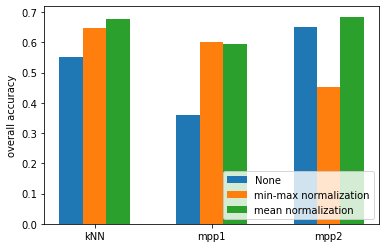

In [52]:
# draw a bar-chart to compare min-max and mean normalization
N = 3
none_acc = (acc_knn, acc_mpp1, acc_mpp2)
minmax_acc = (acc_knn_minmax, acc_mpp1_minmax, acc_mpp2_minmax)
mean_acc = (acc_knn_mean, acc_mpp1_mean, acc_mpp2_mean)

ind = np.arange(N) 
width = 0.2
plt.bar(ind, none_acc, width, label='None')
plt.bar(ind + width, minmax_acc, width, label='min-max normalization')
plt.bar(ind + 2*width, mean_acc, width, label='mean normalization')

plt.ylabel('overall accuracy')
plt.xticks(ind + width, ('kNN', 'mpp1', 'mpp2'))
plt.legend(loc='lower right')
plt.show()

The experiments above indicate that "mean normalization" performs the best. In specific, min-max improve the overall accuracy for knn and mpp1. However, the overall accuracy decreased for mpp2. This may because min-max normalization partialy eliminates the correlations between the features. Therefore, the original assumptions no longer hold. It is better to assume that the features are independent which applies for mpp1. "Mean normalization" improved the overall accuracies for all classifiers. Therefore, we use "mean normalization" for all the following tasks.

In [53]:
# use mean normalization
nHousetrain = mean_normal(Housetrain)
nHouseval = mean_normal(Houseval)
print('mean nornalization is applied.')

mean nornalization is applied.


# Dimension Reduction

We use priciple component analysis (PCA) to reduce the dimension. 

In [54]:
def experiment(tr, target, val):
 
    Val = mylearn.knn(np.array(tr), np.array(target), np.array(val), 8, output=False)
    ClassAcc, OvAcc1 = util.accuracy_score(np.array(valtarget), Val) 
    print(f'Overall Accuracy for knn is {OvAcc1}')

    Val = mylearn.mpp(np.array(tr), np.array(target), np.array(val), 1, probs, output=False)
    ClassAcc, OvAcc2 = util.accuracy_score(np.array(valtarget), Val) 
    print(f'Overall Accuracy for mpp1 is {OvAcc2}')

    Val = mylearn.mpp(np.array(tr), np.array(target), np.array(val), 2, probs, output=False)
    ClassAcc, OvAcc3 = util.accuracy_score(np.array(valtarget), Val) 
    print(f'Overall Accuracy for mpp2 is {OvAcc3}')
    
    return OvAcc1, OvAcc2, OvAcc3

In [56]:
# without dimension reduction
dims = [Houseval.shape[1]]
knn_accs = []
mpp1_accs = []
mpp2_accs = []
acc1, acc2, acc3 = experiment(nHousetrain, traintarget, nHouseval)
knn_accs.append(acc1)
mpp1_accs.append(acc2)
mpp2_accs.append(acc3)

# apply pca 
tolerance = np.linspace(0.1, 0.7, 7)
for t in tolerance:
    pmatrix = mylearn.pca(np.array(nHousetrain), t)
    pHousetrain = np.dot(nHousetrain, pmatrix)
    pHouseval = np.dot(nHouseval, pmatrix)
    print(f"-If tolerance is {t}, demensions reduced from {Housetrain.shape[1]} to {pHousetrain.shape[1]}.")
    dims.append(pHouseval.shape[1])
    acc1, acc2, acc3 = experiment(pHousetrain, traintarget, pHouseval)
    knn_accs.append(acc1)
    mpp1_accs.append(acc2)
    mpp2_accs.append(acc3)

Overall Accuracy for knn is 0.6767123287671233
Overall Accuracy for mpp1 is 0.5945205479452055
Overall Accuracy for mpp2 is 0.684931506849315
-If tolerance is 0.1, demensions reduced from 32 to 20.
Overall Accuracy for knn is 0.673972602739726
Overall Accuracy for mpp1 is 0.5972602739726027
Overall Accuracy for mpp2 is 0.6876712328767123
-If tolerance is 0.2, demensions reduced from 32 to 16.
Overall Accuracy for knn is 0.6794520547945205
Overall Accuracy for mpp1 is 0.6054794520547945
Overall Accuracy for mpp2 is 0.6794520547945205
-If tolerance is 0.3, demensions reduced from 32 to 12.
Overall Accuracy for knn is 0.7041095890410959
Overall Accuracy for mpp1 is 0.6219178082191781
Overall Accuracy for mpp2 is 0.684931506849315
-If tolerance is 0.4, demensions reduced from 32 to 9.
Overall Accuracy for knn is 0.6904109589041096
Overall Accuracy for mpp1 is 0.6438356164383562
Overall Accuracy for mpp2 is 0.684931506849315
-If tolerance is 0.5, demensions reduced from 32 to 6.
Overall Acc

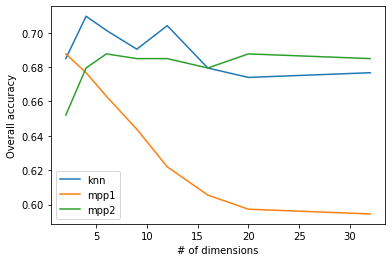

In [57]:
plt.plot(dims, knn_accs, label='knn')
plt.plot(dims, mpp1_accs, label = 'mpp1')
plt.plot(dims, mpp2_accs, label = 'mpp2')
plt.legend()
plt.xlabel('# of dimensions')
plt.ylabel('Overall accuracy')
plt.show()

By increasing the tolerance from 0.1 to 0.7, the number of dimensions gradually reduced from 32 to 2. We expectd that the overall accuracy would decrease as we reduce the dimensions. However, the results show that accuracy increase. This may because that the features are noisy. It is benificial if we removed the noises. From the tests, we think keep 6 dimensions is relatively reasonable.

In [58]:
pmatrix = mylearn.pca(np.array(nHousetrain), 0.5)
pHousetrain = np.dot(nHousetrain, pmatrix)
pHouseval = np.dot(nHouseval, pmatrix)
print(f"-If set tolerance to {0.5}, the # of demensions reduced from {Housetrain.shape[1]} to {pHousetrain.shape[1]}.")

-If set tolerance to 0.5, the # of demensions reduced from 32 to 6.


# MPP

In [59]:
def evaluate(target, prediction, time, clf):
    ClassAcc, OvAcc = util.accuracy_score(np.array(target), prediction) 
    for val in np.unique(target):
        print(f'{clf} accuracy for Class {val} = {ClassAcc[val]}.')
    print(f'Overall Accuracy for for {clf} is {OvAcc}')
    print(f'Training time for {clf} is {time}')

In [64]:
# mpp1
ts = time.time()
Val = mylearn.mpp(pHousetrain, traintarget, pHouseval, 1, probs, output=False)
timerun = time.time() - ts
evaluate(valtarget, Val, timerun,  clf='mpp1')

mpp1 accuracy for Class 0 = 0.22580645161290322.
mpp1 accuracy for Class 1 = 0.8709677419354839.
mpp1 accuracy for Class 2 = 0.7340425531914894.
mpp1 accuracy for Class 3 = 0.2.
mpp1 accuracy for Class 4 = 0.7704918032786885.
Overall Accuracy for for mpp1 is 0.663013698630137
Training time for mpp1 is 0.009940147399902344


In [65]:
# mpp2
ts = time.time()
Val = mylearn.mpp(pHousetrain, traintarget, pHouseval, 2, probs, output=False)
timerun = time.time() - ts
evaluate(valtarget, Val, timerun,  clf='mpp2')

mpp2 accuracy for Class 0 = 0.3870967741935484.
mpp2 accuracy for Class 1 = 0.8306451612903226.
mpp2 accuracy for Class 2 = 0.7340425531914894.
mpp2 accuracy for Class 3 = 0.34545454545454546.
mpp2 accuracy for Class 4 = 0.7868852459016393.
Overall Accuracy for for mpp2 is 0.6876712328767123
Training time for mpp2 is 0.12067747116088867


# Deciosn Tree

In [77]:
from sklearn.tree import DecisionTreeClassifier
from sklearn.tree import export_text

dtree_clf = DecisionTreeClassifier(random_state=2, max_depth=3)
ts = time.time()
dtree_clf.fit(pHousetrain, traintarget)
timerun = time.time() - ts
Val_tree = dtree_clf.predict(pHouseval)
evaluate(valtarget, Val_tree, timerun,  clf='decision tree')

decision tree accuracy for Class 0 = 0.3870967741935484.
decision tree accuracy for Class 1 = 0.8467741935483871.
decision tree accuracy for Class 2 = 0.6382978723404256.
decision tree accuracy for Class 3 = 0.7090909090909091.
decision tree accuracy for Class 4 = 0.5901639344262295.
Overall Accuracy for for decision tree is 0.6904109589041096
Training time for decision tree is 0.001994609832763672


# SVM

In [78]:
from sklearn import svm

svm_clf = svm.SVC()
ts = time.time()
svm_clf.fit(pHousetrain, traintarget)
timerun = time.time() - ts
Val_tree = svm_clf.predict(pHouseval)
evaluate(valtarget, Val_tree, timerun,  clf='svm classifier')

svm classifier accuracy for Class 0 = 0.4838709677419355.
svm classifier accuracy for Class 1 = 0.8629032258064516.
svm classifier accuracy for Class 2 = 0.776595744680851.
svm classifier accuracy for Class 3 = 0.4909090909090909.
svm classifier accuracy for Class 4 = 0.7540983606557377.
Overall Accuracy for for svm classifier is 0.7342465753424657
Training time for svm classifier is 0.015958786010742188
